20240726 접촉 Stiffness 시뮬레이션 비교

* 필요 패키지 사용

In [183]:
import numpy as np
import mujoco
import mujoco.viewer
import mediapy as media

import time
import serpenoid
import serpenoid_gamma

from scipy.signal import find_peaks

* 시뮬레이션 정의 파일 불러오기

In [184]:
debris = mujoco.MjModel.from_xml_path("./contact_testing_fsensor.xml")
data = mujoco.MjData(debris)
renderer = mujoco.Renderer(debris, 720, 1280)


* f스트링 타입으로 변수화

In [185]:
def varying_xml(val:list):
    txt_xml = f"""
 <mujoco model="contact testing">
    <option timestep="0.00093750"/>
    <size memory="10M"/>

    <asset>
        <texture type="skybox" builtin="gradient" width="512" height="512" rgb1=".4 .6 .8" rgb2="0 0 0"/>
        <texture name="texgeom" type="cube" builtin="flat" mark="cross" width="128" height="128"
                 rgb1="0.6 0.6 0.6" rgb2="0.6 0.6 0.6" markrgb="1 1 1"/>
        <texture name="texplane" type="2d" builtin="checker" rgb1=".4 .4 .4" rgb2=".6 .6 .6"
                 width="512" height="512"/>
        <material name="MatPlane" reflectance="0.0" texture="texplane" texrepeat="1 1" texuniform="true"
                  rgba=".7 .7 .7 1"/>
        <material name="capsule" texture="texgeom" texuniform="true" rgba=".4 .9 .6 1" />
        <material name="ellipsoid" texture="texgeom" texuniform="true" rgba=".4 .6 .9 1" />
        <material name="box" texture="texgeom" texuniform="true" rgba=".4 .9 .9 1" />
        <material name="cylinder" texture="texgeom" texuniform="true" rgba=".8 .6 .8 1" />
        <material name="sphere" texture="texgeom" texuniform="true" rgba=".9 .1 .1 1" />

        <mesh name="link_collision" file="./assets/dummy_contact_testing.STL"/>
    </asset>

    <default>
        <default class="collision-mesh">
            <geom type="mesh" mesh="link_collision" mass="0.250" condim="4" rgba="0.5 0.5 0.5 0.4" priority="1" friction="0.7 0.015 0.001" euler="90 90 0"/>
        </default>
    </default>

    <visual>
        <map force="0.1" zfar="30"/>
        <rgba haze="0.15 0.25 0.35 1"/>
        <quality shadowsize="4096"/>
        <global offwidth="1280" offheight="1280"/>
    </visual>

<worldbody>
    <!-- solimp default : "0.9 0.95 0.001 0.5 2" // solref default : "0.02 1" -->
    <geom name="floor" type="plane" size="3 3 .5" priority="2" friction="0.55 0.015 0.001" solimp="{val[0]} {val[1]} {val[2]} {val[3]} {val[4]}" solref="{val[5]} {val[6]}" material="MatPlane"/>

    <body name="debris" pos="0 0 0.43655" euler="0 0 0"> 
        <freejoint name="root"/>
        <geom class="collision-mesh"/> 
        <body>
            <geom name="sensor_body" type="cylinder" size="0.009 0.00075" pos="0.02 -0.00338 -0.0362" mass="0" priority="1" friction="0.7 0.015 0.001"/>
            <site name="sensor" type="cylinder" size="0.009 0.00075" pos="0.02 -0.00338 -0.0362"/>
        </body>
    </body>
</worldbody>

<sensor>
    <force name="force" site="sensor"/>
</sensor>

</mujoco>
    """
    return txt_xml

* 특성 최적화

** 최적화 함수 구현

In [186]:
import matplotlib.pyplot as plt



def opt_J(terrain_x0):
    ###
    # Optimize the terrain parameters
    # Sand
    COR_ref = 0.1776
    MAX_force_ref = 36.0513
    deform_ref = 0.0298
    ###

    contact_force = []
    debris_pos = []

    opt_env = mujoco.MjModel.from_xml_string(varying_xml(terrain_x0))
    opt_data = mujoco.MjData(opt_env)

    t_step = opt_env.opt.timestep
    stepspersecond = int(1/t_step)
    mujoco.mj_resetData(opt_env, opt_data)
    mujoco.mj_forward(opt_env, opt_data)

    for i in range(2*stepspersecond):
        contact_force.append(opt_data.sensordata[2])
        debris_pos.append(opt_data.body("debris").xpos[2])
        mujoco.mj_step(opt_env, opt_data)

    initial_heght = debris_pos[0]
    debris_pos = debris_pos - debris_pos[0]

    pos_peak, _ = find_peaks(debris_pos, prominence=0.00001)
    peak_len = len(pos_peak)

    # plt.plot(debris_pos[0:4000])
    # plt.plot(contact_force)

    if peak_len > 0:
        COR = np.sqrt((initial_heght + debris_pos[pos_peak[0]])/(initial_heght))
    else:
        COR = 0.1

    steady_gnd = np.mean(debris_pos[-30::])

    peak_force = -np.min(contact_force)
    deform = -(0.4 + steady_gnd)

    return (COR - COR_ref)**2 + (peak_force - MAX_force_ref)**2 + (deform - deform_ref)**2


In [194]:
x0 = [0.9, 0.95, 0.001, 0.5, 2, 0.02, 1]
x_min = (0.4,  0.4, 0.0001, 0.1, 1, 0.005, 0.5)
x_max = (0.99, 0.99,   100, 0.9, 5,   100, 10)


from scipy.optimize import minimize, rosen, rosen_der, Bounds

bnds = Bounds(x_min, x_max)
res = minimize(opt_J, 
               x0, 
               method='Nelder-Mead', 
               options={'xatol': 0.5, 'fatol': 1, 'disp': True},
               bounds=bnds
               )

print(res)

       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: 0.00602178129754748
             x: [ 4.399e-01  7.041e-01  7.370e-04  4.159e-01  1.112e+00
                  5.016e-02  4.491e+00]
           nit: 887
          nfev: 1400
 final_simplex: (array([[ 4.399e-01,  7.041e-01, ...,  5.016e-02,
                         4.491e+00],
                       [ 4.398e-01,  7.040e-01, ...,  5.016e-02,
                         4.491e+00],
                       ...,
                       [ 4.399e-01,  7.041e-01, ...,  5.016e-02,
                         4.491e+00],
                       [ 4.396e-01,  7.040e-01, ...,  5.016e-02,
                         4.492e+00]]), array([ 6.022e-03,  6.022e-03,  6.022e-03,  6.022e-03,
                        6.022e-03,  6.022e-03,  6.022e-03,  6.022e-03]))


C:\Users\doore\AppData\Local\Temp\ipykernel_35768\1852953987.py:9: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  res = minimize(opt_J,


In [ ]:
plt.plot(debris_pos[0:4000])

* 시뮬레이션 진행 (영상 렌더링)

In [195]:
t_step = debris.opt.timestep
stepspersecond = int(1/t_step)

frames = []
contact_force = []
debris_pos = []

mujoco.mj_resetData(debris, data)

mujoco.mj_forward(debris, data)

for i in range(2*stepspersecond):
    mujoco.mj_step(debris, data)
    renderer.update_scene(data)
    pixel = renderer.render()

    frames.append(pixel)
    contact_force.append(data.sensordata[2])
    debris_pos.append(data.body("debris").xpos[2])

# media.show_video(frames, fps=stepspersecond)

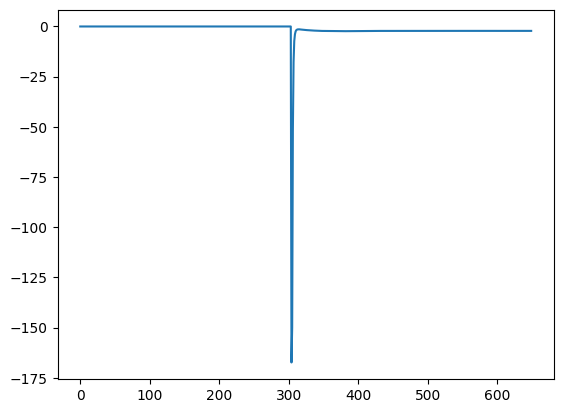

In [196]:
import matplotlib.pyplot as plt


plt.plot(contact_force[0:650])

In [ ]:
plt.plot(debris_pos[0:4000])